In [9]:
import pandas as pd
new_customers_file = 'Customers.csv.xlsx'
transactions_file = 'Transactions.csv.xlsx'
new_customers_df = pd.read_excel(new_customers_file)
transactions_df = pd.read_excel(transactions_file)
new_customers_df.head(), transactions_df.head()


(  ï»¿CustomerID        CustomerName         Region SignupDate
 0         C0001    Lawrence Carroll  South America 2022-07-10
 1         C0002      Elizabeth Lutz           Asia 2022-02-13
 2         C0003      Michael Rivera  South America 2024-03-07
 3         C0004  Kathleen Rodriguez  South America 2022-10-09
 4         C0005         Laura Weber           Asia 2022-08-15,
   ï»¿TransactionID CustomerID ProductID     TransactionDate  Quantity  \
 0           T00001      C0199      P067 2024-08-25 12:38:23         1   
 1           T00112      C0146      P067 2024-05-27 22:23:54         1   
 2           T00166      C0127      P067 2024-04-25 07:38:55         1   
 3           T00272      C0087      P067 2024-03-26 22:55:37         2   
 4           T00363      C0070      P067 2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  )

In [10]:
new_customers_df.columns = new_customers_df.columns.str.strip().str.replace("ï»¿", "")
transactions_df.columns = transactions_df.columns.str.strip().str.replace("ï»¿", "")

customers_missing = new_customers_df.isnull().sum()
transactions_missing = transactions_df.isnull().sum()

new_customers_df.info(), transactions_df.info(), customers_missing, transactions_missing


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CustomerID    200 non-null    object        
 1   CustomerName  200 non-null    object        
 2   Region        200 non-null    object        
 3   SignupDate    200 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TransactionID    1000 non-null   object        
 1   CustomerID       1000 non-null   object        
 2   ProductID        1000 non-null   object        
 3   TransactionDate  1000 non-null   datetime64[ns]
 4   Quantity         1000 non-null   int64         
 5   TotalValue       1000 non-null   float64       
 6   Pri

(None,
 None,
 CustomerID      0
 CustomerName    0
 Region          0
 SignupDate      0
 dtype: int64,
 TransactionID      0
 CustomerID         0
 ProductID          0
 TransactionDate    0
 Quantity           0
 TotalValue         0
 Price              0
 dtype: int64)

In [11]:
transaction_features = transactions_df.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    total_transactions=("TransactionID", "count"),
    avg_transaction_value=("TotalValue", "mean"),
    last_transaction_date=("TransactionDate", "max"),
)
current_date = transactions_df["TransactionDate"].max()
transaction_features["recency_days"] = (current_date - transaction_features["last_transaction_date"]).dt.days
transaction_features = transaction_features.drop(columns=["last_transaction_date"])
merged_data = new_customers_df.merge(transaction_features, on="CustomerID", how="left")
merged_data.fillna({
    "total_spend": 0,
    "total_transactions": 0,
    "avg_transaction_value": 0,
    "recency_days": (current_date - new_customers_df["SignupDate"]).dt.days
}, inplace=True)
merged_data.head()


,CustomerID,CustomerName,Region,SignupDate,total_spend,total_transactions,avg_transaction_value,recency_days
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,5.0,670.904,55.0
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,4.0,465.685,25.0
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,4.0,681.345,125.0
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,8.0,669.360,4.0
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,3.0,678.080,54.0


E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
E:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

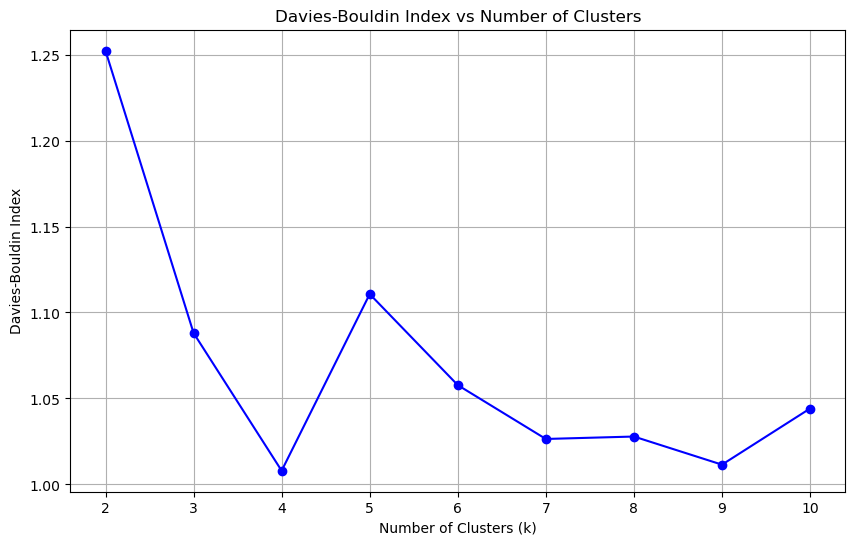

(4, 1.0079761483775083)

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

numeric_features = ["total_spend", "total_transactions", "avg_transaction_value", "recency_days"]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(merged_data[numeric_features])
db_index_values = []
k_values = range(2, 11)
cluster_results = {}
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(normalized_data)
    db_index = davies_bouldin_score(normalized_data, clusters)
    db_index_values.append(db_index)
    cluster_results[k] = {
        "model": kmeans,
        "clusters": clusters,
        "db_index": db_index,
    }
plt.figure(figsize=(10, 6))
plt.plot(k_values, db_index_values, marker='o', linestyle='-', color='b')
plt.title("Davies-Bouldin Index vs Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)
plt.show()
best_k = k_values[db_index_values.index(min(db_index_values))]
best_db_index = min(db_index_values)
best_k, best_db_index


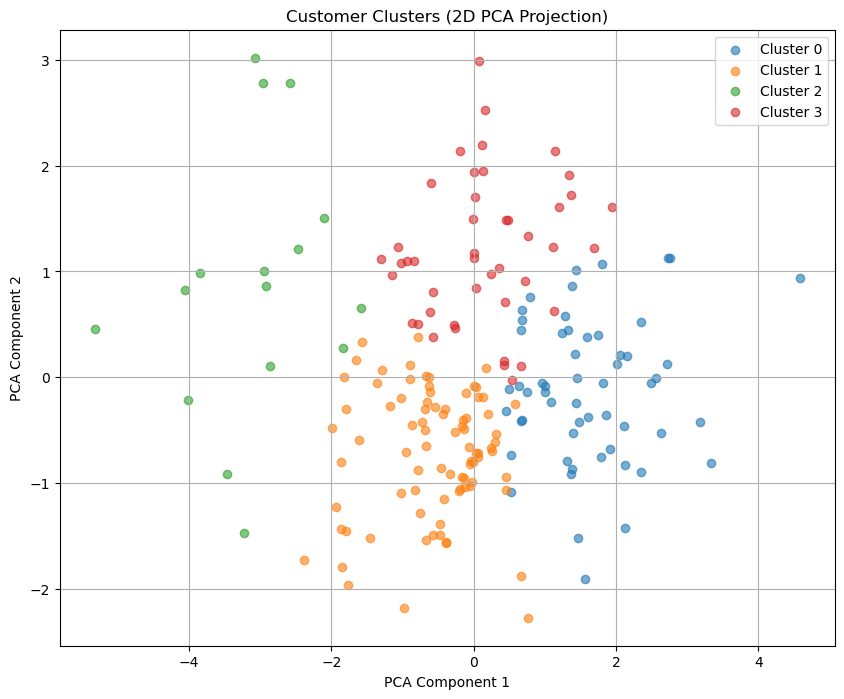

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
best_clusters = cluster_results[best_k]["clusters"]
plt.figure(figsize=(10, 8))
for cluster in range(best_k):
    cluster_points = reduced_data[best_clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}", alpha=0.6)

plt.title("Customer Clusters (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()
